In [2]:
import sys, os
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# 事前分布から関数（w）をサンプル

In [3]:
def polynomial(x, degree):
    """多項式
    """
    return [np.power(x, d) for d in np.arange(0, degree+1)]

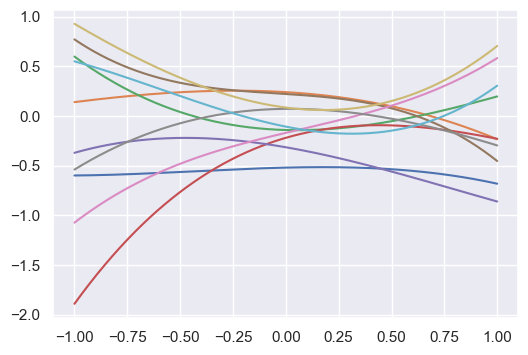

In [4]:
n_degree = 3 # モデルの次数
var_w = 0.1  # wの事前分布の分散
size = 10 # 事前分布からサンプルする個数

# 事前分布からwをサンプリング
m = np.zeros(n_degree+1)
v = var_w * np.identity(n_degree+1)
ws = stats.multivariate_normal.rvs(mean=m, cov=v, size=size)

# plot
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)
xs = np.linspace(-1.0, 1.0, 1000)
for w in ws:
    sample_prior = list(map(lambda x:np.dot(w, polynomial(x=x, degree=n_degree)), xs))
    ax.plot(xs, sample_prior, '-')

In [5]:
# 事前分布の平均パラメータ
m

array([0., 0., 0., 0.])

In [6]:
# 事前分布の精度パラメータ
v

array([[0.1, 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. ],
       [0. , 0. , 0.1, 0. ],
       [0. , 0. , 0. , 0.1]])

# トイデータの取得

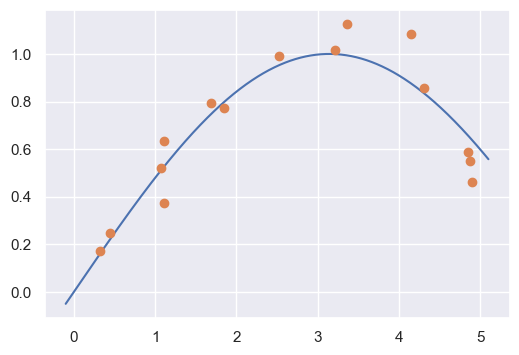

In [7]:
def true_func(x, params=None):
    y = params['gain'] * np.sin(x * params['omega'])
    return y
def observation_model(x, var=1.0, true_model_params=None):
    ty = true_func(x, params=true_model_params)
    y = stats.norm.rvs(loc=ty, scale=np.sqrt(var))
    return y

xmin,xmax = 0, 5
sample_x = xmin + (xmax-xmin)*np.random.rand(15) # 純粋にランダムにサンプル
#sample_x = np.concatenate([(xmin+(4-xmin)*np.random.rand(1)), (4+(xmax-4)*np.random.rand(2))]) # 区間を分けてサンプル


#tfunc_params = {'gain':1., 'omega':1.5}
tfunc_params = {'gain':1., 'omega':0.5}
var_y = 0.01
sample_y = list(map(lambda x:observation_model(x, var=var_y, true_model_params=tfunc_params), sample_x))

# plot
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)
xs = np.linspace(xmin-0.1, xmax+0.1, 1000)
tys = list(map(lambda x:true_func(x, params=tfunc_params), xs))
ax.plot(xs, tys, '-')
ax.plot(sample_x, sample_y, 'o')

In [8]:
# 観測データX
sample_x

array([1.10702664, 1.07591751, 4.89515382, 3.36379767, 4.14297167,
       4.8529214 , 4.86785826, 1.8479765 , 0.31667281, 1.68445298,
       1.11526834, 2.51842778, 0.44526282, 4.30582798, 3.21152539])

In [9]:
# 観測データY
sample_y

[0.37280578188609054,
 0.5217961977404778,
 0.46310887621703034,
 1.1266707994547094,
 1.0858575281973528,
 0.5874161077226905,
 0.5510527237296962,
 0.7744154135081972,
 0.17253343599708312,
 0.7959609536201501,
 0.6321180640356783,
 0.9910077555043458,
 0.24803958992463324,
 0.8567392535339626,
 1.0156391798163558]

# ベイズ線形回帰の学習（重みwの事後分布）

In [10]:
# 事後分布の分散共分散行列
def outer_feature(x, degree=n_degree):
    feature = polynomial(x=x, degree=degree)
    return np.outer(feature, feature)
sum_feature = sum(map(outer_feature, sample_x))
S_hat_inv = (1.0/var_y) * sum_feature + (1.0/var_w) * np.identity((n_degree+1))
S_hat = np.linalg.inv(S_hat_inv)

# 事後分布の平均ベクトル
sum_yf = sum(map(lambda xy:np.array(polynomial(x=xy[0], degree=n_degree)) * xy[1], zip(sample_x, sample_y)))
tmp_ar = (1.0/var_y) * sum_yf
mu_hat = (np.dot(S_hat, tmp_ar[:,np.newaxis])).flatten()

In [11]:
# 事後分布の平均パラメータ
mu_hat

array([ 0.11578451,  0.25610348,  0.1162165 , -0.03097483])

In [12]:
# 事後分布の精度パラメータ
S_hat

array([[ 9.94535156e-03, -1.37944914e-02,  5.16726179e-03,
        -5.68787448e-04],
       [-1.37944914e-02,  2.52866736e-02, -1.08140318e-02,
         1.28589147e-03],
       [ 5.16726179e-03, -1.08140318e-02,  5.05656344e-03,
        -6.35875747e-04],
       [-5.68787448e-04,  1.28589147e-03, -6.35875747e-04,
         8.28258025e-05]])

# 事後分布からwのサンプル

In [13]:
# 事後分布からwをサンプル
sample_post_ws = stats.multivariate_normal.rvs(mean=mu_hat, cov=S_hat, size=10)

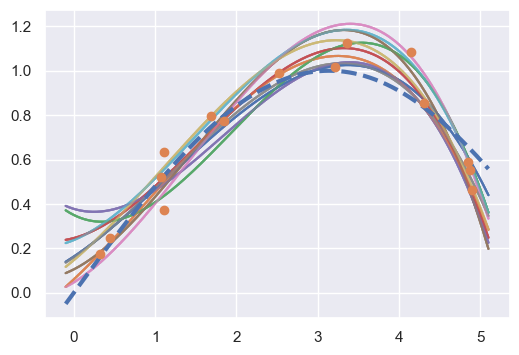

In [14]:
# plot
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)
for w in ws:
    sample_prior = list(map(lambda x:np.dot(sample_post_ws, polynomial(x=x, degree=n_degree)), xs))
    ax.plot(xs, sample_prior, '-', alpha=0.3)
ax.plot(xs, tys, '--', lw=3)
ax.plot(sample_x, sample_y, 'o')

In [15]:
sample_post_ws

array([[ 0.16300069,  0.24473337,  0.08257743, -0.02351585],
       [ 0.06032459,  0.34329065,  0.07462075, -0.02614727],
       [ 0.35003199, -0.18139967,  0.28830277, -0.04946888],
       [ 0.24620483,  0.09810084,  0.17353598, -0.03778466],
       [ 0.37764368, -0.10950928,  0.23686542, -0.04338115],
       [ 0.10522547,  0.18799914,  0.1801691 , -0.04185948],
       [ 0.04647322,  0.22508764,  0.16985531, -0.0397893 ],
       [ 0.15998438,  0.24875788,  0.09007546, -0.02582405],
       [ 0.14675119,  0.31016801,  0.09294447, -0.02910169],
       [ 0.23721407,  0.15260264,  0.16137743, -0.03657808]])

# 予測分布の算出

In [16]:
def mu_pred(x, mu_tr, n_degree=n_degree):
    feature = (np.array(polynomial(x, degree=n_degree)))[:, np.newaxis]
    return (np.dot(mu_tr.T, feature)).flatten()
def var_pred(x, sig_tr):
    feature = (np.array(polynomial(x, degree=n_degree)))[:, np.newaxis]
    fsf = np.dot(feature.T, sig_tr)
    fsf = np.dot(fsf, feature)
    return (var_y + fsf).flatten()

mu_s_s = np.array(list(map(lambda x:mu_pred(x, mu_tr=mu_hat), xs))).flatten()
var_s_s = np.array(list(map(lambda x:var_pred(x, sig_tr=S_hat), xs))).flatten()

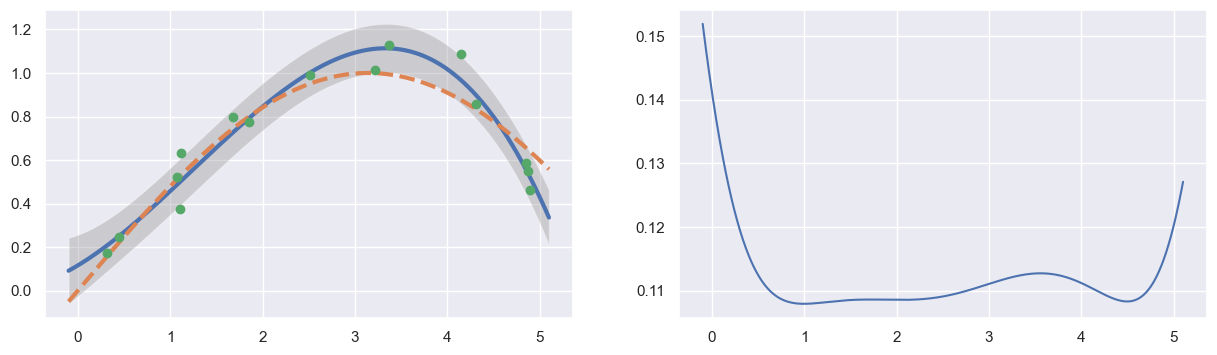

In [17]:
# plot
fig = plt.figure(figsize=(15, 4))
ax = fig.subplots(1,2)

# sampled function(trained W)
"""
for w in ws:
    sample_prior = list(map(lambda x:np.dot(sample_post_ws, polynomial(x=x, degree=n_degree)), xs))
    ax[0].plot(xs, sample_prior, '-', color='gray', alpha=0.3)
"""
# mean predicted function
ax[0].plot(xs, mu_s_s, lw=3)

# predicted area
sig_s_s = np.sqrt(var_s_s)
lb = mu_s_s - sig_s_s
ub = mu_s_s + sig_s_s
ax[0].fill_between(xs, lb, ub, facecolor='gray',alpha=0.3)

# True Function
ax[0].plot(xs, tys, '--', lw=3)

# Sampled Data
ax[0].plot(sample_x, sample_y, 'o')

## 予測の分散（不確実性）のプロッt
ax[1].plot(xs, sig_s_s)

In [18]:
xmin,xmax = -2, 7
xs = np.linspace(xmin-0.1, xmax+0.1, 1000)
tys = list(map(lambda x:true_func(x, params=tfunc_params), xs))

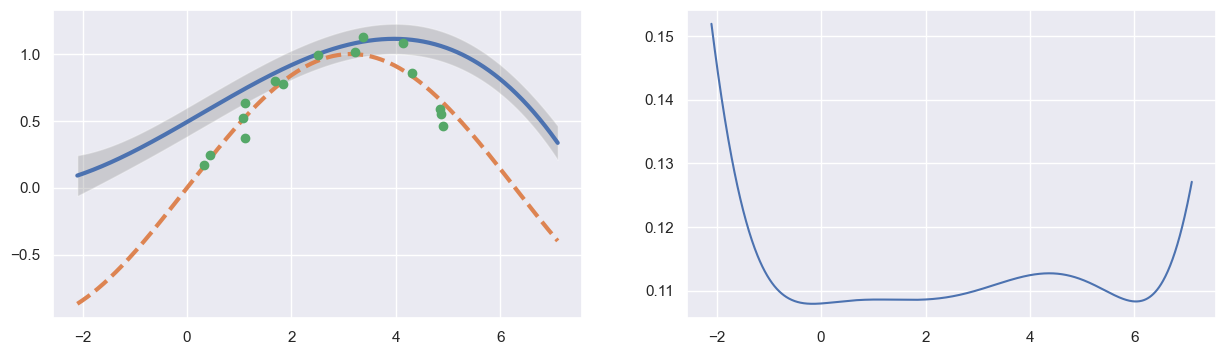

In [19]:
# plot
fig = plt.figure(figsize=(15, 4))
ax = fig.subplots(1,2)
"""
# sampled function(trained W)
for w in ws:
    sample_prior = list(map(lambda x:np.dot(sample_post_ws, polynomial(x=x, degree=n_degree)), xs))
    ax[0].plot(xs, sample_prior, '-', color='gray', alpha=0.3)
"""
# mean predicted function
ax[0].plot(xs, mu_s_s, lw=3)

# predicted area
sig_s_s = np.sqrt(var_s_s)
lb = mu_s_s - sig_s_s
ub = mu_s_s + sig_s_s
ax[0].fill_between(xs, lb, ub, facecolor='gray',alpha=0.3)

# True Function
ax[0].plot(xs, tys, '--', lw=3)

# Sampled Data
ax[0].plot(sample_x, sample_y, 'o')

## 予測の分散（不確実性）のプロッt
ax[1].plot(xs, sig_s_s)